In [18]:
list.of.packages = c('grf','ggplot2','quantregForest','fields')
new.packages = list.of.packages[!(list.of.packages
                     %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(
           new.packages, repos='http://cran.us.r-project.org')

suppressWarnings(library(grf, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(quantregForest, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(ggplot2, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(fields, quietly = TRUE, warn.conflicts = FALSE))


In this module we will see how to build a random forest for conditional average treatment effects (CATE) or conditional average treatment effects on the treated (CATT).

Consider a slight modification of the example from the package documentation (https://github.com/swager/grf/tree/master/r-package/grf/R)

Here we demonstrate why we need an "honest" estimation strategy and when CATT will be different from CATE

The first example is the case where treatment is randomly assigned, but the effect of the treatment is a function of the first covariate

In [19]:
# Generate data.
set.seed(271828)
n = 2000; p = 10
X = matrix(rnorm(n*p), n, p)
X.test = matrix(0, 101, p)
X.test[,1] = seq(-2, 2, length.out = 101)
# Perform treatment effect estimation.
W = rbinom(n, 1, 0.5)
Y = pmax(X[,1], 0) * W + X[,2] + pmin(X[,3], 0) + rnorm(n)

A naive way of approaching this problem is to build the tree with the same sample from which we estimate the treatment effects. We can observe what happens in this case by setting "honest" to false in the causal_forest package

In [20]:
te.forest = causal_forest(X, Y, W,
                num.trees = 4000, honest=FALSE)
# grow and estimate the treatment effects w/ the same sample
print(te.forest)                                         
# Examine the forest that we grew based on variable importance 

GRF forest object of type causal_forest 
Number of trees:  4000 
Number of training samples: 2000 
Variable importance: 
    1     2     3     4     5     6     7     8     9    10 
0.741 0.023 0.058 0.023 0.030 0.025 0.042 0.010 0.022 0.025 


As should be the case the most important variable is $x_1$, although we are picking up more noise than would be ideal here. 

How did we do in terms of treatment effect estimation?

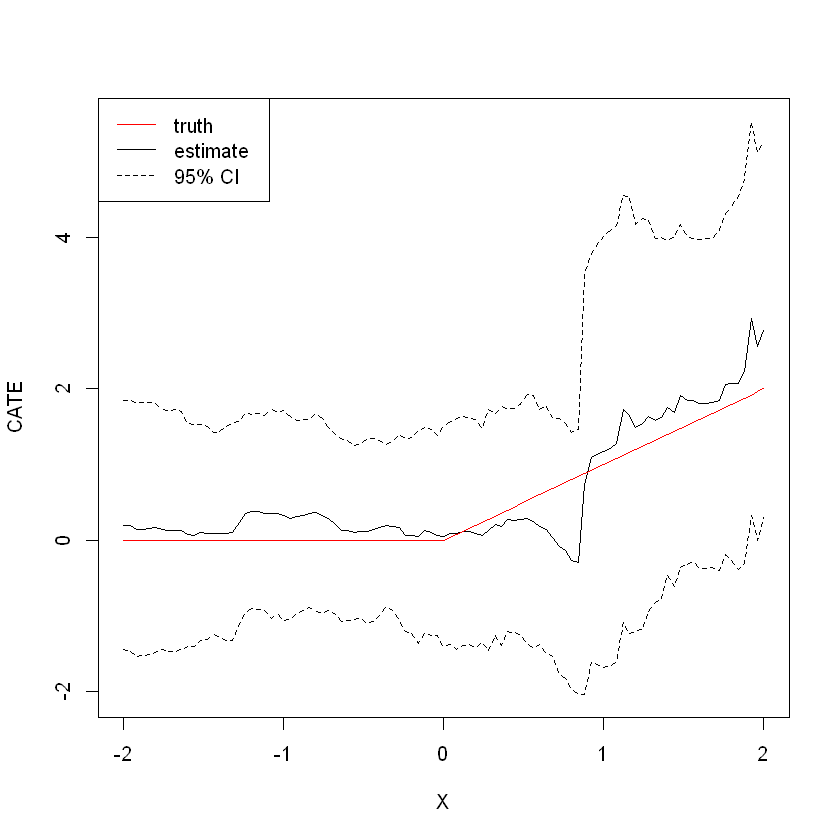

In [21]:
te.hat = predict(te.forest, X.test, estimate.variance = TRUE)           
# predict CATE for range of x1

sigma.hat = sqrt(te.hat$variance.estimates)
plot(X.test[,1], te.hat$predictions, 
     ylim = range(te.hat$predictions + 1.96 * sigma.hat,
                  te.hat$predictions - 1.96 * sigma.hat, 0, 2),
                  xlab = "X", ylab = "CATE", type = "l")

lines(X.test[,1], te.hat$predictions + 1.96 * sigma.hat, col = 1, lty = 2)
lines(X.test[,1], te.hat$predictions - 1.96 * sigma.hat, col = 1, lty = 2)
lines(X.test[,1], pmax(0, X.test[,1]), col = 2, lty = 1)
legend("topleft",c('truth','estimate','95% CI'),lty=c(1,1,2),
       col=c('red','black','black'))

In this example the estimate is not too bad, but we don't do a good job capturing the changepoint.

Let's see what happens when we use the "honest" method. Let's build the tree and estimate the treatment effects with different subsamples.

In [22]:
te.forest = causal_forest(X, Y, W,
                num.trees = 4000)
# grow and estimate the treatment effects w/ sample split
print(te.forest)
# Examine the forest that we grew based on variable importance 

GRF forest object of type causal_forest 
Number of trees:  4000 
Number of training samples: 2000 
Variable importance: 
    1     2     3     4     5     6     7     8     9    10 
0.692 0.032 0.049 0.033 0.035 0.033 0.041 0.023 0.030 0.032 


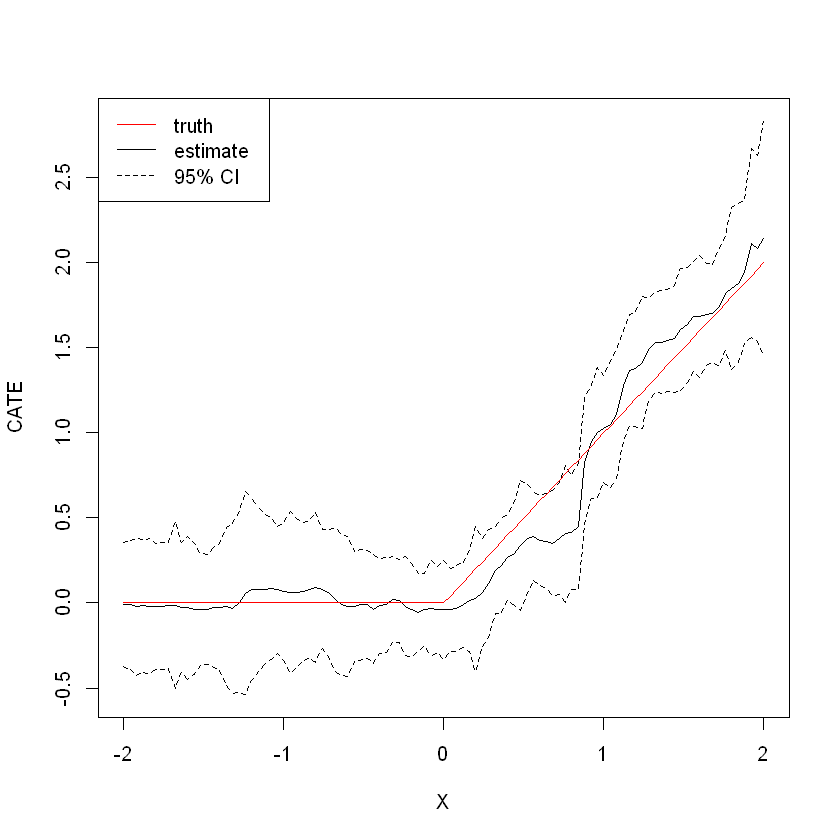

In [23]:
te.forest = causal_forest(X, Y, W, num.trees = 4000)
# grow and estimate the treatment effects w/ the diff samples
te.hat = predict(te.forest, X.test, estimate.variance = TRUE)
# predict CATE for range of x1

sigma.hat = sqrt(te.hat$variance.estimates)
plot(X.test[,1], te.hat$predictions, ylim = range(
            te.hat$predictions + 1.96 * sigma.hat, 
            te.hat$predictions - 1.96 * sigma.hat, 0, 2), 
            xlab = "X", ylab = "CATE", type = "l")

lines(X.test[,1], te.hat$predictions + 1.96 * sigma.hat, col = 1, lty = 2)
lines(X.test[,1], te.hat$predictions - 1.96 * sigma.hat, col = 1, lty = 2)
lines(X.test[,1], pmax(0, X.test[,1]), col = 2, lty = 1)
legend("topleft",c('truth','estimate','95% CI'),lty=c(1,1,2),
       col=c('red','black','black'))

We pick up the changepoint much better here. You can also see how much tighter the confidence bands are in this case.

In this example there isn't much of a difference between CATT and CATE as the treatment is randomly assigned.

In [24]:
# Estimate the conditional average treatment effect on the full sample (CATE).
print('CATE:')
estimate_average_effect(te.forest, target.sample = "all")
# Estimate the conditional average treatment effect on the treated sample (CATT).
print('CATT:')
estimate_average_effect(te.forest, target.sample = "treated")


[1] "CATE:"


estimate    std.err 
0.37788937 0.04598694

[1] "CATT:"


estimate    std.err 
0.37603535 0.04608133

We can make the probability of treatment be a function of an observable. In this case let the probability of treatment be a function of $x_2$

In [8]:

# Generate data.
set.seed(271828)
n = 2000; p = 10
X = matrix(rnorm(n*p), n, p)
X.test = matrix(0, 101, p)
X.test[,1] = seq(-2, 2, length.out = 101)
# Perform treatment effect estimation.
sel = 1/(1+exp(-X[,2]))
W = rbinom(n, 1, sel)
Y = pmax(X[,1], 0) * W + X[,2] + pmin(X[,3], 0) + rnorm(n)

In [9]:
te.forest = causal_forest(X, Y, W)          
# grow the forest
te.hat = predict(te.forest, X.test)       
# the estimates are based on a subsample not included to grow the forest

# Estimate the conditional average treatment effect on the full sample (CATE).
print('CATE:')
estimate_average_effect(te.forest, target.sample = "all")

# Estimate the conditional average treatment effect on the treated sample (CATT).
print('CATT:')
estimate_average_effect(te.forest, target.sample = "treated")

[1] "CATE:"


estimate    std.err 
0.39514880 0.05166585

[1] "CATT:"


estimate    std.err 
0.41918554 0.05767077

Here we can see how assignment effects the estimates for both CATT and CATE.

In addition to heterogeneous effects, Forests can also be used to estimate quantile effects.

Just to demonstrate how this works consider the very simple model:

Let $y = x_1\varepsilon$

In [10]:
n = 2000; p = 20
X = matrix(rnorm(n*p), n, p)
X.test = matrix(0, 101, p)
X.test[,1] = seq(-2, 2, length.out = 101)
Y = X[,1] * rnorm(n)

# Train a quantile forest.
q.forest = quantile_forest(X, Y, quantiles=c(0.1, 0.5, 0.9))

Now that we have quantile predictions for $\tau = \{0.1,0.5,0.9\}$ we can plot these

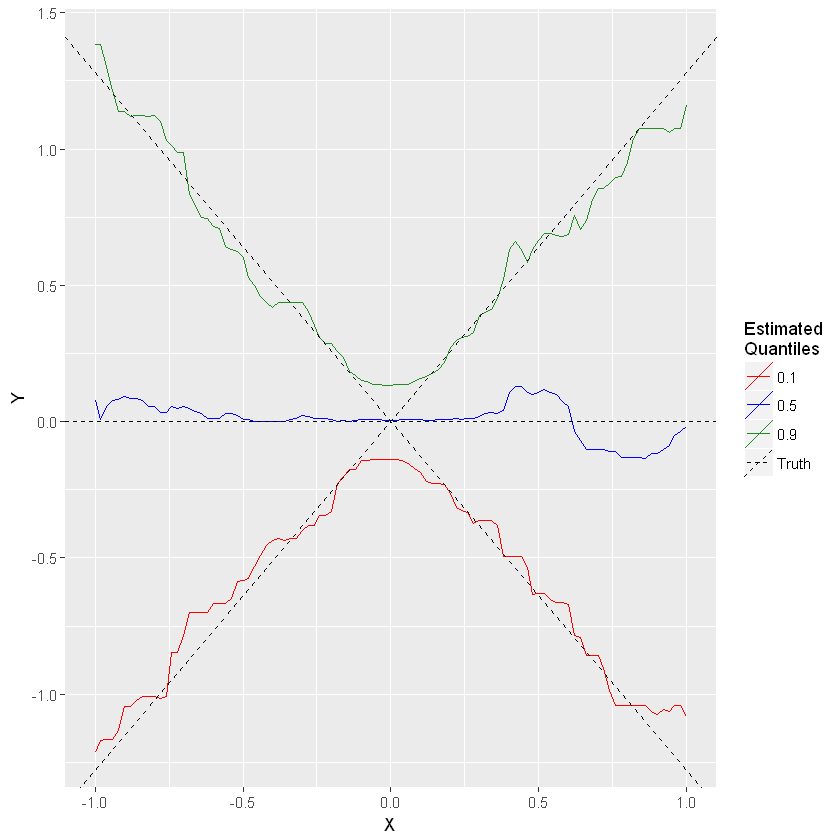

In [17]:
# Make predictions.
q.hat = predict(q.forest, X.test)
quantiles = data.frame(cbind(X.test[,1],q.hat))


ggplot(quantiles,aes(X.test[,1],q.hat[,1]))+
geom_line(aes(color='0.1')) + 
geom_line(aes(X.test[,1],q.hat[,2],color='0.5')) + 
geom_line(aes(X.test[,1],q.hat[,3],color='0.9')) +
geom_abline(aes(color='Truth',intercept = 0, slope = qnorm(0.9)), linetype = 'dashed') +
geom_abline(intercept = 0, slope = -qnorm(0.9), linetype = 'dashed') +
geom_abline(intercept = 0, slope = qnorm(0.5), linetype = 'dashed') +
labs(x = "X") +
labs(y = "Y") +
scale_colour_manual(
    name = "Estimated\nQuantiles", 
    values = c('0.1'="red",'0.5'="blue",'0.9'= "forestgreen",'Truth'='black'),
    guide = guide_legend(
    override.aes = list(linetype = c(1,1,1,2))))


How accurate are our predictions for other quantiles? Let's check $\tau  = \{0.3,0.7\}$

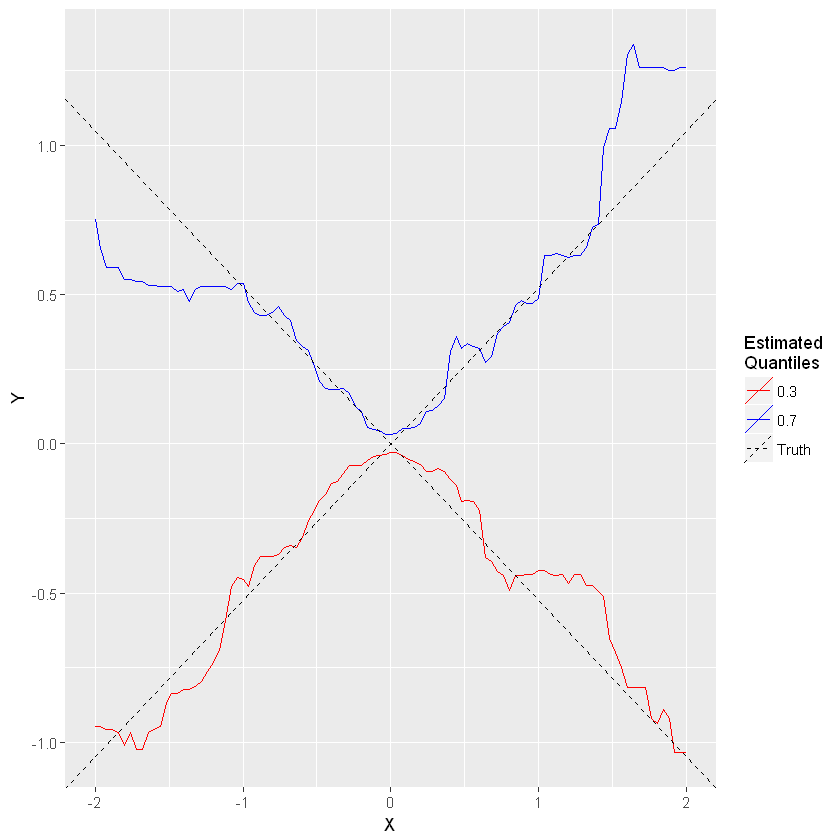

In [12]:
# Make predictions for different quantiles than those used in training.
q.hat = predict(q.forest, X.test, quantiles=c(0.3, 0.7))
quantiles = data.frame(cbind(X.test[,1],q.hat))

ggplot(quantiles,aes(X.test[,1],q.hat[,1]))+
geom_line(aes(color='0.3')) + 
geom_line(aes(X.test[,1],q.hat[,2],color='0.7')) + 
geom_abline(aes(color='Truth',intercept = 0, 
                slope = qnorm(0.7)), linetype = 'dashed') +
geom_abline(intercept = 0, slope = -qnorm(0.7), linetype = 'dashed') +
labs(x = "X") +
labs(y = "Y") +
scale_colour_manual(
    name = "Estimated\nQuantiles", 
    values = c('0.3'="red",'0.7'="blue",'Truth'='black'),
    guide = guide_legend(
    override.aes = list(linetype = c(1,1,2))))

Looks pretty good! We capture the quantile effects even when we don't directly estimate them.

EXERCISE: 

Examine the effect of a randomly assigned treatment that varies with the sign of two covariates:

$y = -1_{sign(x_1)=sign(x_2)}w + 1_{sign(x_1)\neq sign(x_2)}w+min\{x_3,0\}+\varepsilon$